In [11]:
%matplotlib inline
import numpy as np
import scipy as sp
from scipy import signal
import scipy.io as io
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from os import path
from sklearn import metrics, svm, preprocessing, datasets, linear_model
from sklearn.model_selection import ShuffleSplit, StratifiedShuffleSplit, cross_val_score, train_test_split

In [12]:
# generamos un electrodo promedio por cada persona 
# (promediando los 5 electrodos del enunciado que se encuentran juntos)
# y los guardamos en disco. De esta manera a partir de ahora vamos a trabajar solo con esos archivos que son 
# mucho más livianos y tiene toda la información que necesitamos, 894 epochs por cada paciente.

electrodos_a_promediar = [7, 43, 79, 130, 184]

for t in ['P', 'S']:
    for i in range(1,11): 
        try:
            data_file = path.join('./data/',t) + "%02d" % (i) + '.mat'
            elec_prom_file = './dumps/elec_prom_' + t + "%02d" % (i) + '.dmp'
            data = io.loadmat(data_file)['data']
            electrodo_promedio = data[:,electrodos_a_promediar,:].mean(axis=1)
            electrodo_promedio.dump(elec_prom_file)
        except Exception as exception:
            print(str(exception))
            pass

[Errno 2] No such file or directory: './data/P01.mat'
[Errno 2] No such file or directory: './data/P02.mat'
[Errno 2] No such file or directory: './data/P03.mat'
[Errno 2] No such file or directory: './data/P04.mat'
[Errno 2] No such file or directory: './data/P05.mat'
[Errno 2] No such file or directory: './data/P06.mat'
[Errno 2] No such file or directory: './data/P07.mat'
[Errno 2] No such file or directory: './data/P08.mat'
[Errno 2] No such file or directory: './data/P09.mat'
[Errno 2] No such file or directory: './data/P10.mat'
[Errno 2] No such file or directory: './data/S01.mat'
[Errno 2] No such file or directory: './data/S02.mat'
[Errno 2] No such file or directory: './data/S03.mat'
[Errno 2] No such file or directory: './data/S04.mat'
[Errno 2] No such file or directory: './data/S05.mat'
[Errno 2] No such file or directory: './data/S06.mat'
[Errno 2] No such file or directory: './data/S07.mat'
[Errno 2] No such file or directory: './data/S08.mat'
[Errno 2] No such file or di

In [13]:
def calculate_welchs(data):
    welchs_by_epoch = np.empty((len(data),2,101))

    for i, epoch in enumerate(data):
        f,p = signal.welch(x=epoch, fs=250)
        welchs_by_epoch[i] = np.array([f,p])
    
    return welchs_by_epoch

In [4]:

welchs = []

for i_type, t in enumerate(['P', 'S']):
    for i in range(1,11):
        try:
            file = './dumps/elec_prom_' + t + "%02d" % (i) + '.dmp'
            print(file)
            data = np.load(file)
            welchs.append(calculate_welchs(data)) 
            #print(data.shape)
            #print(repr(calculate_welchs(data)))
        except Exception as exception:
            print(str(exception))
            pass

./dumps/elec_prom_P01.dmp


/usr/local/lib/python2.7/dist-packages/scipy/signal/spectral.py:1633: UserWarning: nperseg = 256 is greater than input length  = 201, using nperseg = 201
  .format(nperseg, input_length))


./dumps/elec_prom_P02.dmp
./dumps/elec_prom_P03.dmp
./dumps/elec_prom_P04.dmp
./dumps/elec_prom_P05.dmp
./dumps/elec_prom_P06.dmp
./dumps/elec_prom_P07.dmp
./dumps/elec_prom_P08.dmp
./dumps/elec_prom_P09.dmp
./dumps/elec_prom_P10.dmp
./dumps/elec_prom_S01.dmp
./dumps/elec_prom_S02.dmp
./dumps/elec_prom_S03.dmp
./dumps/elec_prom_S04.dmp
./dumps/elec_prom_S05.dmp
./dumps/elec_prom_S06.dmp
./dumps/elec_prom_S07.dmp
./dumps/elec_prom_S08.dmp
./dumps/elec_prom_S09.dmp
./dumps/elec_prom_S10.dmp


In [14]:
def calculate_epochs_power_mean(welchs_by_epoch, frequency_range):
    freqs = welchs_by_epoch[0,0,:]
    freqs_idxs = np.where((freqs>=frequency_range[0]) * (freqs<frequency_range[1]))
    return welchs_by_epoch[:,1,freqs_idxs].mean(axis=2)



frequencies_ranges = {"delta": (0,4), "theta": (4,8), "alpha": (8,13), "beta": (13,30), "gamma": (30,125)}
# matriz [paciente,banda_freq,epochs,potencia]

potencias_mean_std = np.zeros((20,5,2))
for i in range(20):
    for freq_idx,frequency_range in enumerate(frequencies_ranges.values()):
        frequency_epochs_power_means = calculate_epochs_power_mean(welchs[i],frequency_range)
        potencias_mean_std[i,freq_idx,0] = frequency_epochs_power_means.mean()
        potencias_mean_std[i,freq_idx,1] = frequency_epochs_power_means.std()

        #frequency_power_means.dump(name + 'power_means.dmp')

In [48]:
[0]*10

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [49]:
column_names_mean = list(map(lambda x: x+"_mean",frequencies_ranges.keys()))
df_mean = pd.DataFrame(preprocessing.scale(potencias_mean_std[:,:,0]),columns=column_names_mean)
column_names_std = list(map(lambda x: x+"_std",frequencies_ranges.keys()))
df_std = pd.DataFrame(preprocessing.scale(potencias_mean_std[:,:,1]),columns=column_names_std)

labels = list([0]*10 + [1]*10)
df_labels = pd.DataFrame({"labels":labels})
tabla = pd.concat([df_mean,df_std,df_labels],axis=1)

tabla

,theta_mean,alpha_mean,beta_mean,gamma_mean,delta_mean,theta_std,alpha_std,beta_std,gamma_std,delta_std,labels
0,-0.217285,-0.615304,-0.378778,-0.302662,0.398470,0.269945,-0.520973,0.342162,-0.009318,1.354776,0
1,0.608135,-0.697167,-0.790002,-0.251627,0.743224,0.580236,-0.663055,-0.850326,-0.255594,0.555005,0
2,1.216150,-0.529393,-0.719615,-0.537576,2.341435,1.360838,-0.551691,-1.010966,-0.790427,2.071140,0
3,1.280443,-0.416504,-0.691420,-0.595026,0.555134,1.055690,-0.376569,-0.649470,-0.630276,0.680326,0
4,0.771707,-0.514563,-0.201065,0.102021,1.673580,0.361377,-0.563311,-0.611631,-0.097719,1.218577,0
5,0.076607,-0.236513,-0.437895,-0.640285,0.902070,0.152077,-0.239414,-0.084829,-0.801907,1.018425,0
6,0.212998,-0.687344,-0.414019,0.020293,0.970275,0.049960,-0.673183,-0.186525,1.147780,0.834867,0
7,-0.922474,-0.798451,-1.223363,-0.597616,-0.635269,-0.921870,-0.742939,-1.216570,-0.549190,-0.324027,0
8,1.019400,-0.621971,-0.519804,-0.449248,0.099139,1.047667,-0.585347,-0.418705,-0.662994,-0.029924,0
9,-0.004764,-0.656034,-0.589504,-0.408690,0.987717,0.256349,-0.638570,-0.353685,0.219537,1.041334,0


In [193]:
def graficar_roc(table, values_column_name, labels_column_name,positivo):

    fpr, tpr, thresholds = metrics.roc_curve( \
        table[labels_column_name].values, \
        table[values_column_name].values, \
        pos_label=positivo, drop_intermediate=False)
   
    roc_auc = metrics.auc(fpr, tpr)
   
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
       

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC for {0}'.format(values_column_name))
    plt.legend(loc="lower right")
    plt.show()


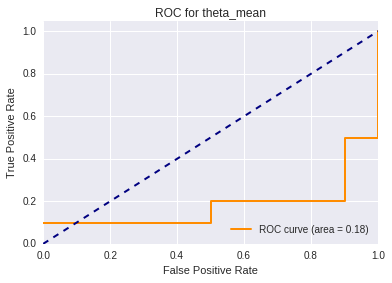

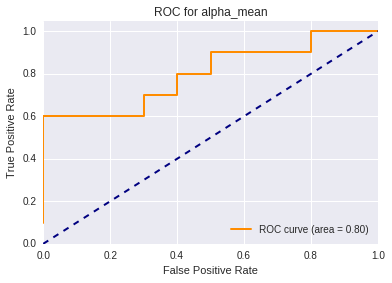

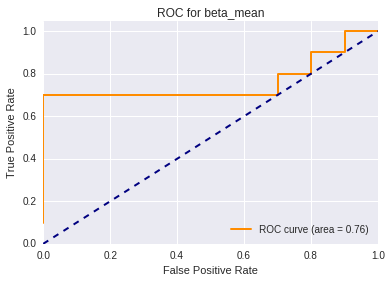

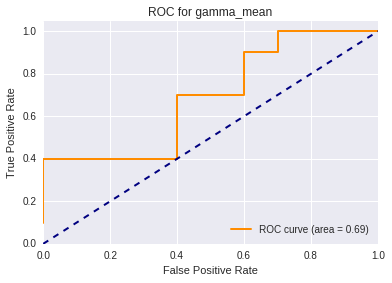

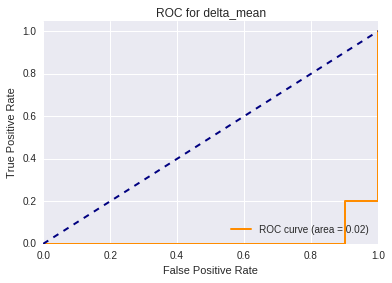

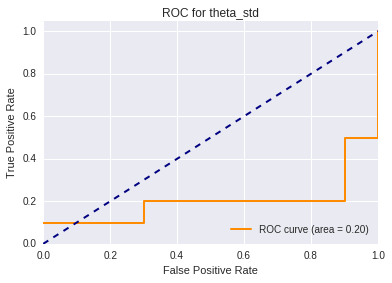

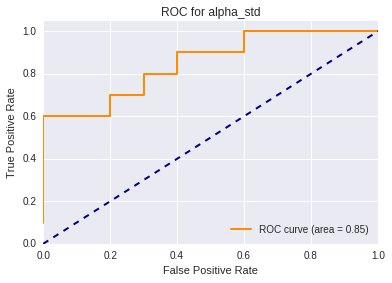

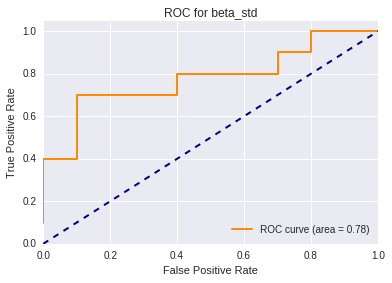

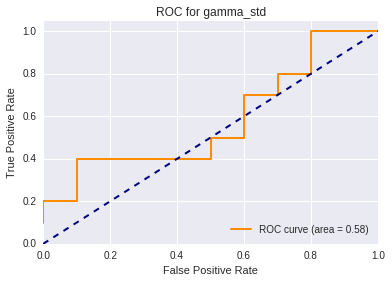

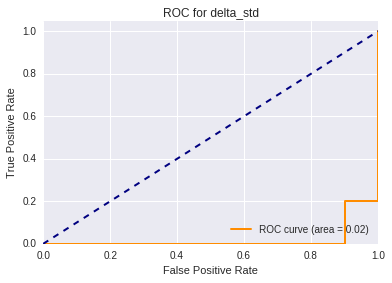

In [194]:
for feature in (column_names_mean + column_names_std):
    graficar_roc(tabla,feature, 'labels', 1)


Logistic Regression

In [195]:
for feature in (column_names_mean + column_names_std):
    X = tabla.loc[:,feature].reshape(-1, 1)
    y = tabla.loc[:,'labels']
    clf = svm.SVC()
    scores = cross_val_score(clf, X,y)
    print("Accuracy %s : %0.2f (+/- %0.2f)" % (feature,scores.mean(), scores.std() * 2))

# X son todas los features con sus respectivos valores para cada sample
X = tabla.iloc[:,:-1]
# Y son todos los labels de los samples, representados como 0 si es un paciente P y 1 si es un paciente de tipo S
y = tabla.loc[:,'labels']
# print(Y)
clf = svm.SVC()
scores = cross_val_score(clf, X,y)
# El score promedio y el intervalo de confianza con 95% del score estimado
print("Accuracy %s: %0.2f (+/- %0.2f)" % ('con todos los features',scores.mean(), scores.std() * 2))

Accuracy theta_mean : 0.75 (+/- 0.14)
Accuracy alpha_mean : 0.79 (+/- 0.18)
Accuracy beta_mean : 0.74 (+/- 0.20)
Accuracy gamma_mean : 0.65 (+/- 0.04)
Accuracy delta_mean : 0.89 (+/- 0.16)
Accuracy theta_std : 0.71 (+/- 0.18)
Accuracy alpha_std : 0.75 (+/- 0.14)
Accuracy beta_std : 0.60 (+/- 0.14)
Accuracy gamma_std : 0.42 (+/- 0.24)
Accuracy delta_std : 0.78 (+/- 0.31)
Accuracy con todos los features: 0.94 (+/- 0.16)


In [155]:
feature = 'delta_mean'
X =  tabla.loc[:,feature]
y = tabla.loc[:,'labels']
sss = StratifiedShuffleSplit(n_splits=2, test_size=0.1, random_state=0)

for train_index, test_index in sss.split(X, y):
#     X_train, X_test, y_train, y_test = train_test_split(tabla.loc[train_index,'delta_mean'], tabla.loc[train_index,'labels'], test_size=0.4, random_state=0)
    X_train, X_test = X[train_index].reshape(-1, 1), X[test_index].reshape(-1, 1)
    y_train, y_test = y[train_index].reshape(-1, 1), y[test_index].reshape(-1, 1)
    clf = svm.SVC(kernel='linear', C=1).fit(X_train, y_train)
    print(clf.score(X_test, y_test))


0.5
0.5


Support Vector Machine

In [196]:

X = np.array(labels)
y = np.array(labels)
sss = StratifiedShuffleSplit(n_splits=2, test_size=0.1, random_state=0)



for train_index, test_index in sss.split(X, y):
    X_train = tabla.iloc[train_index, :-1]
    X_test = tabla.iloc[test_index, :-1]
    y = tabla.iloc[train_index, -1]
    y_test = tabla.iloc[test_index, -1]
    clf = svm.SVC()
    clf.fit(X_train, y)

    print("TRA:", train_index)
    print("TEST:", test_index)
    print(clf.predict(X_test))
    print(clf.score(X_test,y_test))
#    print("Tra: ", X_train)
    print("X_test: ", X_test)
    print("Y_test: ", y_test)
    #    print("X_train: ", X_train)
#    print("y: ", y)
    print(type(X_train))
#    print(type(y))
#    print(clf.predict(tabla.iloc[test_index, :-1]))

('TRA:', array([ 7, 16, 15,  4, 17, 19, 11,  2,  9,  1, 12, 10, 13,  6,  8,  0, 18,
        3]))
('TEST:', array([ 5, 14]))
[0 1]
1.0
('X_test: ',     theta_mean  alpha_mean  beta_mean  gamma_mean  delta_mean  theta_std  \
5     0.076607   -0.236513  -0.437895   -0.640285    0.902070   0.152077   
14    2.519334    2.417702   2.797602   -0.344844    0.024437   2.320447   

    alpha_std  beta_std  gamma_std  delta_std  
5   -0.239414 -0.084829  -0.801907   1.018425  
14   2.850395  3.043605  -0.632244  -0.063760  )
('Y_test: ', 5     0
14    1
Name: labels, dtype: int64)
<class 'pandas.core.frame.DataFrame'>
('TRA:', array([10, 12,  4,  6, 13, 15,  7, 11, 19,  8, 16,  9,  0, 18,  1,  5, 17,
        2]))
('TEST:', array([ 3, 14]))
[0 1]
1.0
('X_test: ',     theta_mean  alpha_mean  beta_mean  gamma_mean  delta_mean  theta_std  \
3     1.280443   -0.416504  -0.691420   -0.595026    0.555134   1.055690   
14    2.519334    2.417702   2.797602   -0.344844    0.024437   2.320447   

    alph

In [25]:


diabetes = datasets.load_diabetes()
X = diabetes.data[:150]
y = diabetes.target[:150]
lasso = linear_model.Lasso()
print(X[0])
print(y[0])
print(cross_val_score(lasso, X, y))  

[ 0.03807591  0.05068012  0.06169621  0.02187235 -0.0442235  -0.03482076
 -0.04340085 -0.00259226  0.01990842 -0.01764613]
151.0
[ 0.33150734  0.08022311  0.03531764]
